In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from Bio import SeqIO

# Extract sequence IDs from the FASTA file. 

Some IDs have improper headers, since they contain spaces. Since we will be doing clustering, we will extract the ID of the sequence from the header (last value in the | brackets), and save the corrected fasta file.`

In [2]:
import re

seq_iterator = SeqIO.parse(open("../data/phosphosite_sequences/Phosphosite_seq.fasta"), 'fasta')
records = []
for seq in seq_iterator:
    # extract sequence id
    seq_id = seq.description.split('|')[-1]
    seq_desc = re.sub(' ', '_', seq.description)
    records.append(SeqIO.SeqRecord(seq.seq, seq_id, description=seq_desc))

In [3]:
seq_iterator = SeqIO.parse(open("../data/phosphosite_sequences/Phosphosite_seq_fixed.fasta"), 'fasta')
i = 0
records = []
for seq in seq_iterator:
    if '|' in seq.id:
        print(seq.id)
        continue
    # extract sequence id
    seq_id = seq.description.split('|')[-1]
    seq_desc = re.sub(' ', '_', seq.description)
    records.append(SeqIO.SeqRecord(seq.seq, seq_id, description=seq_desc))
    i +=1

GN:Nsmce1|NSMCE1_iso4|mouse| is missing the uniprot id. It seems to be A0A6P5Q324. It is added to the fixed .fasta file. Other proteins in this list seem to have malformed entries in the original .fasta file, so they are removed from the fixed version.

In [4]:
SeqIO.write(records, '../data/phosphosite_sequences/Phosphosite_seq_fixed.fasta', 'fasta')

62807

In [7]:
seed = 42

In [19]:
prot_info = pd.read_json('../data/phosphosite_sequences/phosphosite_df.json')
prot_info

,id,sites,sequence
0,A0A024R4G9,"[14, 16, 20]",MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...
1,A0A075B759,"[40, 79, 93, 119]",MVNSVVFFEITRDGKPLGRISIKLFADKIPKTAENFRALSTGEKGF...
2,A0A087WP46,"[359, 972, 973, 974, 988, 997, 1000, 1005, 101...",MARDGAEQPDSGPLPRPSPCPQEDRASNLMPPKPPRTWGLQLQGPS...
3,A0A087WPF7,"[32, 43, 622, 626, 798, 941, 956, 1031, 1038, ...",MDGPTRGHGLRKKRRSRSQRDRERRSRAGLGTGAAGGIGAGRTRAP...
4,A0A087WQ53,[58],MGQNNNVTEFILLGLTQDPAGQKVLFVMFLLIYIVKIVGNLLIVGT...
...,...,...,...
42252,XP_997087,"[347, 907, 915, 918, 927]",MENFLALMNSISDTWMSPSCMDIAMDMGIAFVCGAGLFFLLLPFLK...
42253,YP_009725299,"[504, 660, 661, 794, 1826]",APTKVTFGDDTVIEVQGYKSVNITFELDERIDKVLNEKCSAYTVEL...
42254,YP_009725305,[5],NNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLS...
42255,YP_009725309,[56],AENVTGLFKDCSKVITGLHPTQAPTHLSVDTKFKTEGLCVDIPGIP...


In [20]:
clusters = pd.read_csv('../data/clustered30_new.tsv', sep='\t', names=['cluster_rep', 'cluster_mem'])
clusters

,cluster_rep,cluster_mem
0,Q8CH79,Q8CH79
1,Q8CH79,Q12797-3
2,Q9NQ86-3,Q9NQ86-3
3,O88656,O88656
4,O88656,Q9R0Q6
...,...,...
62803,Q9BUD6,Q9BUD6
62804,Q9BUD6,Q8BMS2
62805,Q9BUD6,Q9WV75
62806,A6NEK1,A6NEK1


In [4]:
clusters['cluster_rep'].unique().shape

(17993,)

In [4]:
joined = prot_info.join(clusters.set_index('cluster_mem'), on='id', how='left').drop_duplicates('id')

Keep only sequences with length < 1023, becasue ESM has max input size of 1024 and tokenizer will add the [CLS] and [EOS] tokens.

In [5]:
joined = joined[joined['sequence'].apply(lambda x: len(x) < 1023)]
joined

,id,sites,sequence,cluster_rep
0,A0A024R4G9,"[14, 16, 20]",MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...,A0A024R4G9
1,A0A075B759,"[40, 79, 93, 119]",MVNSVVFFEITRDGKPLGRISIKLFADKIPKTAENFRALSTGEKGF...,P62937
4,A0A087WQ53,[58],MGQNNNVTEFILLGLTQDPAGQKVLFVMFLLIYIVKIVGNLLIVGT...,Q8NGM1
5,A0A087WQ89,"[18, 26]",METPIQREIRRSCEREESLRRSRGLSPGRAGEELIELRVRPVLSRP...,Q96FF7
6,A0A087WQP5,"[98, 102, 107]",MGCCGCGGCGGCGGCGCGGCGCGGCGCGGCGCGGCGCGGCGCGGCG...,A0A087WQP5
...,...,...,...,...
42248,XP_988512,[156],MKHPRHVTGCGGGSRGHVRGVATRGSRALGCGLQRGAAGGAGVAAG...,XP_988512
42251,XP_996053,"[19, 399, 400, 401, 542, 545, 803, 804, 807]",MGKFLALMNSIIDSWMGPSSMDIAMDIGIAFMCGAGLFFLLQRFLK...,XP_997087
42254,YP_009725305,[5],NNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLS...,NP_828867
42255,YP_009725309,[56],AENVTGLFKDCSKVITGLHPTQAPTHLSVDTKFKTEGLCVDIPGIP...,YP_009725309


In [ ]:
reps = set(joined.cluster_rep.unique())
members = set(joined.id.unique())

# Representatives that are not in the filtered dataset
missing = set.difference(reps, members)
missing

{'Q14406',
 'D4ACG6',
 'Q925Q3',
 'Q60587',
 'Q4V8A6',
 'Q9NQ84-2',
 'Q9WUU7',
 'Q6ZUJ4',
 'Q5U2S1',
 'Q6ZNF0',
 'Q9UNE0-2',
 'Q5M828',
 'Q8BH53',
 'A0A0G2K2A7',
 'Q6ZPV6',
 'Q80WF0',
 'A2CE44',
 'B5DFF2',
 'Q9Z0V6',
 'Q66JT7',
 'Q6S5C2',
 'Q64527',
 'Q6P6C2-1',
 'Q8R035',
 'Q4KLH3',
 'XP_006228289',
 'P63090',
 'B5DEL7',
 'Q6P7P8',
 'M0R8B6',
 'Q5PQN2',
 'O95551-2',
 'P97378',
 'Q6ZR52-2',
 'Q6ZUS6-4',
 'Q15334',
 'NP_001178747',
 'Q6UXF7',
 'Q5JX71',
 'Q9NYP7-2',
 'Q9P121-4',
 'P62916',
 'Q6P597-3',
 'Q9R144',
 'Q9H8T0-2',
 'Q15906-2',
 'XP_343054',
 'Q8N584',
 'Q9D0D4',
 'P04089',
 'Q9HCN6',
 'P07151',
 'M0R8L5',
 'O88532',
 'P70397-2',
 'Q8CFD5',
 'Q5BJP3',
 'P21816',
 'Q68FQ4',
 'XP_003752181',
 'Q9D2F5',
 'Q9HB65',
 'Q7Z3D6-2',
 'Q5PPP3',
 'B1ANY3',
 'Q62472',
 'Q92800-2',
 'P37242',
 'Q8NDY8',
 'Q8BFW9',
 'Q9D855',
 'Q8CAE2',
 'P17702',
 'Q9UGK3-2',
 'P58281-2',
 'P31948-2',
 'Q07646',
 'P85970',
 'Q9Y5P6-2',
 'Q15833-3',
 'Q3MHL7',
 'O95628-6',
 'Q9NUQ6-3',
 'F1M1E4',
 'Q96PD5-

In [11]:
len(missing)

3079

The missing set is a set of cluster representatives with length >= 1023, thus not included in this filtered version. We need to choose a different representative for the members of these clusters. It will be the longest protein from the cluster that is still remaining in the set.

In [12]:
to_fix = joined[joined['cluster_rep'].apply(lambda x: x in missing)]
to_fix

,id,sites,sequence,cluster_rep
14,A0A096MJN4,"[170, 306]",MIKHFLEDNSDDAELSKFVKDFPGSEPCHPTESKTRVARPQILEPR...,O43236-4
21,A0A0B4J1G0,[235],MWQLLLPTALVLTAFSGIQAGLQKAVVNLDPKWVRVLEEDSVTLRC...,P27645
30,A0A0G2JTM7,"[279, 289, 483]",MGKKHKKHKSDRHFYEEYVEKPLKLVLKVGGSEVTELSTGSSGHDS...,Q9NPI1-2
34,A0A0G2JUG7,"[105, 107, 109, 110, 162, 180, 224, 342, 416, ...",MACRRRYLSSLETGSSLSTDRYSVEGEAPSSETGTSLDSPSAYHQG...,B4DGC5
60,A0A0G2KA14,[404],MFGRSRSWVGGGHGKSSRNIHSLDHLKYLYHVLTKNTTVTEQNRNL...,Q2KHT3
...,...,...,...,...
42222,XP_577119,[12],MEVFLMIRRKKTTIFIEAQELTTVLELKRIVQGILKRPPEEQLLFK...,P62870
42232,XP_578472,"[76, 78, 83]",MAMVCAFLTILVVMSHWSTCCLGCNLPRTHNLTVLKQMSRQSPVSC...,B1AYH7
42237,XP_621234,"[23, 293, 303]",MDHKLQNSDGRQPVLAIKNQTLTEFILLGLTDAPELQVCVFLFLLL...,P47883
42251,XP_996053,"[19, 399, 400, 401, 542, 545, 803, 804, 807]",MGKFLALMNSIIDSWMGPSSMDIAMDIGIAFMCGAGLFFLLQRFLK...,XP_997087


In [13]:
fix_grouped = to_fix.groupby('cluster_rep')

In [14]:
def collapse_fn(group : pd.DataFrame):
    #print(group['sequence'])
    #print(group)
    lens = group['sequence'].apply(lambda x: len(x))
    new_rep = lens.argmax()
    group['new_rep'] = group.iloc[new_rep].id
    return group

fixed = fix_grouped.apply(collapse_fn)

C:\Users\Samo\AppData\Local\Temp\ipykernel_15724\3061083446.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fixed = fix_grouped.apply(collapse_fn)


In [15]:
fixed

id                                         sites  \
cluster_rep                                                                  
A0A024RBG1  7937      O95989                                [30, 131, 160]   
            9042      P0C027                                         [150]   
            9043      P0C028                                    [148, 150]   
            29828     Q8NFP7        [11, 67, 148, 150, 154, 158, 159, 162]   
            32894     Q96G61        [11, 67, 148, 150, 154, 158, 159, 162]   
...                      ...                                           ...   
XP_913389   14595     P62851                 [26, 55, 65, 69, 74, 93, 109]   
            14596     P62852                         [26, 55, 69, 93, 113]   
XP_997087   1577      B7ZWJ3                [368, 489, 914, 918, 919, 920]   
            19226     Q3V0M1           [141, 148, 368, 914, 918, 919, 920]   
            42251  XP_996053  [19, 399, 400, 401, 542, 545, 803, 804, 807]   

                                                            sequence  \
cluster_rep                                                            
A0A024RBG1  7937   MMKLKSNQTRTYDGDGYKKRAACLCFRSESEEEVLLVSSSRHPDRW...   
            9042   MKCKPNQTRTYDPEGFKKRAACLCFRSEREDEVLLVSSSRYPDRWI...   
            9043   MKCKPNQTRTYDPEGFKKRAACLCFRSEREDEVLLVSSSRYPDRWI...   
            29828  MKCKPNQTRTYDPEGFKKRAACLCFRSEREDEVLLVSSSRYPDRWI...   
            32894  MKCKPNQTRTYDPEGFKKRAACLCFRSEREDEVLLVSSSRYPDRWI...   
...                                                              ...   
XP_913389   14595  MPPKDDKKKKDAGKSAKKDKDPVNKSGGKAKKKKWSKGKVRDKLNN...   
            14596  MPPKDDKKKKDAGKSAKKDKDPVNKSGGKAKKKKWSKGKVRDKLNN...   
XP_997087   1577   MENFLSLMNSIIDPWMSNSSMDIAMDMTIGFMCGVGLFFLLIPFLK...   
            19226  MENFLSLMNSIIDSWMSNSSMDIAMDMTIGFMCGVGLFFLLIPFLK...   
            42251  MGKFLALMNSIIDSWMGPSSMDIAMDIGIAFMCGAGLFFLLQRFLK...   

                  cluster_rep new_rep  
cluster_rep                            
A0A024RBG1  7937   A0A024RBG1  Q9NZJ9  
            9042   A0A024RBG1  Q9NZJ9  
            9043   A0A024RBG1  Q9NZJ9  
            29828  A0A024RBG1  Q9NZJ9  
            32894  A0A024RBG1  Q9NZJ9  
...                       ...     ...  
XP_913389   14595   XP_913389  P62851  
            14596   XP_913389  P62851  
XP_997087   1577    XP_997087  B7ZWJ3  
            19226   XP_997087  B7ZWJ3  
            42251   XP_997087  B7ZWJ3  

[7744 rows x 5 columns]

In [16]:
fixed = fixed.reset_index(level='cluster_rep', drop=True)
fixed

,id,sites,sequence,cluster_rep,new_rep
7937,O95989,"[30, 131, 160]",MMKLKSNQTRTYDGDGYKKRAACLCFRSESEEEVLLVSSSRHPDRW...,A0A024RBG1,Q9NZJ9
9042,P0C027,[150],MKCKPNQTRTYDPEGFKKRAACLCFRSEREDEVLLVSSSRYPDRWI...,A0A024RBG1,Q9NZJ9
9043,P0C028,"[148, 150]",MKCKPNQTRTYDPEGFKKRAACLCFRSEREDEVLLVSSSRYPDRWI...,A0A024RBG1,Q9NZJ9
29828,Q8NFP7,"[11, 67, 148, 150, 154, 158, 159, 162]",MKCKPNQTRTYDPEGFKKRAACLCFRSEREDEVLLVSSSRYPDRWI...,A0A024RBG1,Q9NZJ9
32894,Q96G61,"[11, 67, 148, 150, 154, 158, 159, 162]",MKCKPNQTRTYDPEGFKKRAACLCFRSEREDEVLLVSSSRYPDRWI...,A0A024RBG1,Q9NZJ9
...,...,...,...,...,...
14595,P62851,"[26, 55, 65, 69, 74, 93, 109]",MPPKDDKKKKDAGKSAKKDKDPVNKSGGKAKKKKWSKGKVRDKLNN...,XP_913389,P62851
14596,P62852,"[26, 55, 69, 93, 113]",MPPKDDKKKKDAGKSAKKDKDPVNKSGGKAKKKKWSKGKVRDKLNN...,XP_913389,P62851
1577,B7ZWJ3,"[368, 489, 914, 918, 919, 920]",MENFLSLMNSIIDPWMSNSSMDIAMDMTIGFMCGVGLFFLLIPFLK...,XP_997087,B7ZWJ3
19226,Q3V0M1,"[141, 148, 368, 914, 918, 919, 920]",MENFLSLMNSIIDSWMSNSSMDIAMDMTIGFMCGVGLFFLLIPFLK...,XP_997087,B7ZWJ3


In [56]:
clusters.set_index('cluster_mem').loc['XP_996053']

cluster_rep    XP_997087
Name: XP_996053, dtype: object

In [57]:
joined['cluster_rep'][fixed.index] = fixed['new_rep']

C:\Users\Samo\AppData\Local\Temp\ipykernel_15724\1254770192.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  joined['cluster_rep'][fixed.index] = fixed['new_rep']


In [19]:
joined.loc[42251]

id                                                     XP_996053
sites               [19, 399, 400, 401, 542, 545, 803, 804, 807]
sequence       MGKFLALMNSIIDSWMGPSSMDIAMDIGIAFMCGAGLFFLLQRFLK...
cluster_rep                                               B7ZWJ3
Name: 42251, dtype: object

In [77]:
joined.shape

(35546, 4)

In [21]:
len(joined['cluster_rep'].unique())

13116

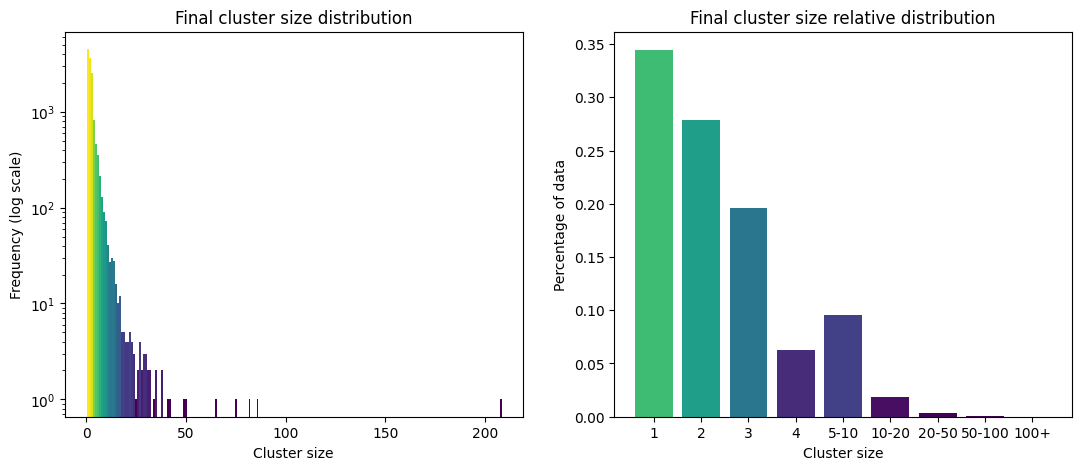

In [50]:
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np

def plot_cluster_sizes(ax,  clusters, cmap='viridis', title=None):
    cmap = colormaps['viridis']
    counts = np.bincount(clusters.groupby('cluster_rep').count()['id'])
    colors = np.zeros_like(counts, np.float32)
    mask = counts > 0
    nonzero = counts[mask]
    nonzero = np.log(nonzero) / np.log(nonzero).max()
    colors[mask] = nonzero
    colors = cmap(colors)
    ax.bar(np.arange(len(counts)), counts, color=colors)
    ax.set_xlabel('Cluster size')
    ax.set_ylabel('Frequency (log scale)')
    ax.set_yscale('log')
    ax.set_title(title)

def plot_binned_cluster_dist(ax,  clusters, cmap='viridis', title=None):
    cmap = colormaps['viridis']
    group_sizes = clusters.groupby('cluster_rep').count().to_numpy().flatten()
    bins = [1, 2, 3, 4, 5, 10, 20, 50, 100, 1000]
    bins = [1, 2, 3, 4, 5, 10, 20, 50, 100, 1000]
    hist = np.histogram(group_sizes, bins=bins)
    labels = [str(i) for i in bins[:-1]]
    for i in range(4, len(labels) - 1):
        labels[i] = labels[i] + '-' + labels[i + 1]

    labels[-1] = labels[-1] + '+'
    colors = cmap(hist[0] * 2 / np.sum(hist[0]))
    ax.bar(labels, hist[0] / np.sum(hist[0]), color=colors)
    ax.set_xlabel('Cluster size')
    ax.set_ylabel('Percentage of data')
    ax.set_title(title)

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
plot_cluster_sizes(ax[0], joined, title='Final cluster size distribution')
plot_binned_cluster_dist(ax[1], joined, title='Final cluster size relative distribution')

plt.savefig('../img/cluster_dist.png')

## Some more stats

In [61]:
n_sites = joined['sites'].apply(lambda x: len(x))
lengths = joined['sequence'].apply(lambda x: len(x))
print(f"Avg. number of sites: {n_sites.mean()} +- {n_sites.std()}")
print(f'Median number of sites:{n_sites.median()}')
print(f'Avg. sequence length: {lengths.mean()} +- {lengths.std()}')
print(f'Median sequence length: {lengths.median()}')


Avg. number of sites: 6.767596916671355 +- 8.795929822116943
Median number of sites:4.0
Avg. sequence length: 467.41290159230294 +- 231.70597433190633
Median sequence length: 436.0


In [95]:
n_sites = prot_info['sites'].apply(lambda x: len(x))
lengths = prot_info['sequence'].apply(lambda x: len(x))
print(f"Avg. number of sites: {n_sites.mean()} +- {n_sites.std()}")
print(f'Median number of sites:{n_sites.median()}')
print(f'Avg. sequence length: {lengths.mean()} +- {lengths.std()}')
print(f'Median sequence length: {lengths.median()}')

Avg. number of sites: 8.965047211112951 +- 16.23211987412551
Median number of sites:4.0
Avg. sequence length: 666.4395721418937 +- 697.2050363703224
Median sequence length: 498.0


In [ ]:
phosphorylated_buffer = {'S' : 0,
                  'T' : 0,
                  'Y' : 0}

total_buffer= {'S' : 0,
                  'T' : 0,
                  'Y' : 0,
                  'Other' : 0}

def count_phosphorylated(row):
    sites = set([int(i) for i in row['sites']])
    for i in range(len(row['sequece'])):
        if row['sequece'] in total_buffer.keys():
            if i in sites:
                

In [99]:
lengths.sort_values()

15139       22
9197        24
9196        24
28245       24
24161       31
         ...  
31448    14507
4990     33467
41962    34252
31499    34350
414      35213
Name: sequence, Length: 42257, dtype: int64

In [101]:
prot_info.loc[lengths.sort_values()[-5:].index]

,id,sites,sequence
31448,Q8WXI7,"[27, 35, 54, 63, 66, 68, 69, 70, 84, 95, 97, 1...",MLKPSGLPGSSSPTRSLMTGSRSTKATPEMDSGLTGATLSPKTSTG...
4990,NP_035782,[10609],MTTQAPMFTQPLQSVVVLEGSTATFEAHVSGSPVPEVSWFRDGQVI...
41962,XP_008773743,"[214, 233, 236, 266, 281, 283, 288, 290, 299, ...",MTTQAPTFTQPLQSVVVLEGSAATFEAHISGSPVPEVSWFRDGQVI...
31499,Q8WZ42,"[57, 112, 204, 206, 214, 219, 263, 265, 267, 2...",MTTQAPTFTQPLQSVVVLEGSTATFEAHISGFPVPEVSWFRDGQVI...
414,A2ASS6,"[233, 236, 262, 264, 266, 269, 281, 283, 288, ...",MTTQAPMFTQPLQSVVVLEGSTATFEAHVSGSPVPEVSWFRDGQVI...


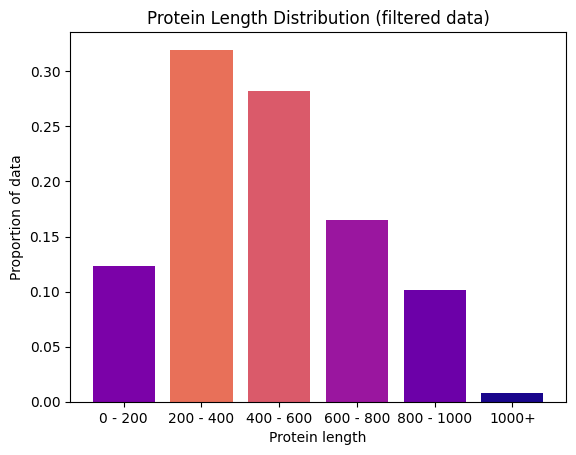

In [74]:
def plot_length_dist(lengths, ax, title=None):
    cmap = colormaps['plasma']
    brackets = [i * 200 for i in range(7)]
    hist = np.histogram(lengths, brackets)
    y = [f"{hist[1][i]} - {hist[1][i + 1]}" for i in range(len(hist[1]) - 1)]
    y[-1] = f"{hist[1][-2]}+"
    colors = cmap(hist[0] * 2 / np.sum(hist[0]))
    ax.bar(y, hist[0] / np.sum(hist[0]), color=colors)

    ax.set_xlabel('Protein length')
    ax.set_ylabel('Proportion of data')
    ax.set_title(title)

fig, ax = plt.subplots()
plot_length_dist(lengths, ax, 'Protein Length Distribution (filtered data)')
plt.savefig('../img/length_dist_filtered')

In [83]:
residue_buffer

{'S': 239633, 'T': 85300, 'Y': 53853, 'Other': 50}

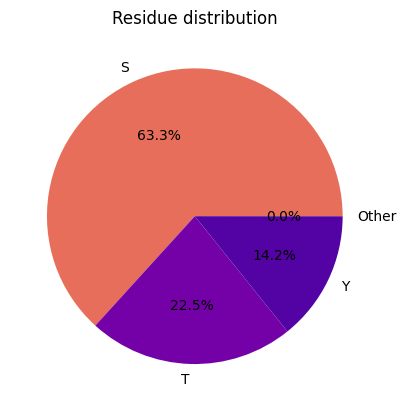

In [90]:
def plot_residue_pie(residue_counts : set, ax, title=None):
    labels = list(residue_counts.keys())
    total = sum([val for val in residue_counts.values()])
    sizes = [val / total for val in residue_counts.values()]

    cmap = colormaps['plasma']
    colors = cmap(sizes)

    ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    ax.set_title(title)

fig, ax = plt.subplots()
plot_residue_pie(residue_buffer, ax, 'Residue distribution')


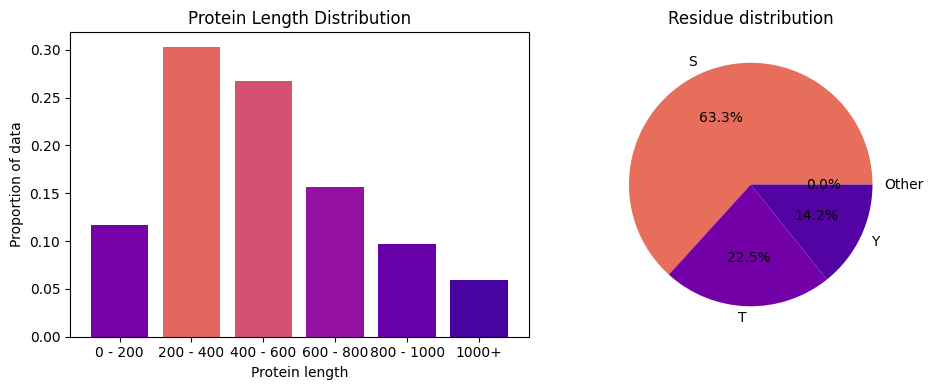

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_length_dist(prot_info.sequence.apply(lambda x: len(x)), ax[0], 'Protein Length Distribution')
plot_residue_pie(residue_buffer, ax[1], 'Residue distribution')
fig.tight_layout()
plt.savefig('../img/length_res_dist_orig')

### Plot the same data for the filtered dataset

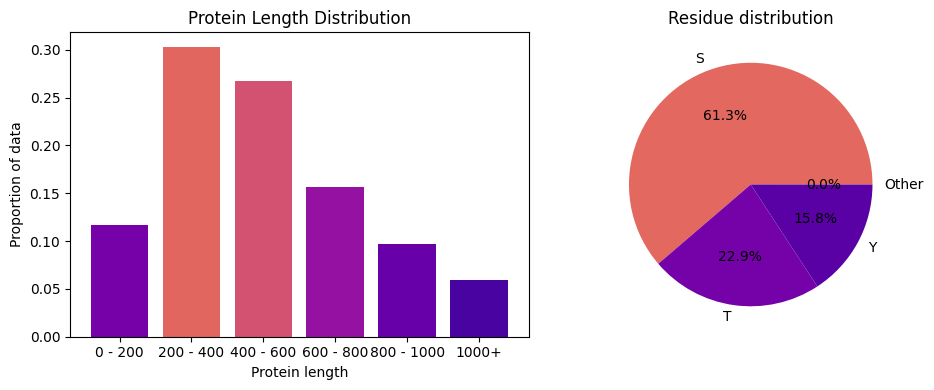

In [97]:
residue_buffer = {'S' : 0,
                  'T' : 0,
                  'Y' : 0,
                  'Other' : 0}

def count_sites(indices, sequence):
    for i in indices:
        if sequence[i] not in residue_buffer:
            residue_buffer['Other'] += 1
            continue
        residue_buffer[sequence[i]] += 1

joined[['sites', 'sequence']].apply(lambda row: count_sites([int(idx) - 1 for idx in row['sites']], row['sequence']), axis=1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_length_dist(prot_info.sequence.apply(lambda x: len(x)), ax[0], 'Protein Length Distribution')
plot_residue_pie(residue_buffer, ax[1], 'Residue distribution')
fig.tight_layout()
plt.savefig('../img/length_res_dist_filtered.png')

In [55]:
reps = joined['cluster_rep'].unique()
reps

array(['A0A024R4G9', 'P62937', 'Q8NGM1', ..., 'XP_988512', 'NP_828867',
       'YP_009725309'], dtype=object)

In [22]:
rep_mask = joined['id'].apply(lambda x : x in reps)
rep_df = joined[rep_mask]
rep_df['length'] = rep_df['sequence'].apply(lambda x: len(x))

C:\Users\Samo\AppData\Local\Temp\ipykernel_13412\3933978370.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rep_df['length'] = rep_df['sequence'].apply(lambda x: len(x))


In [23]:
rep_df

,id,sites,sequence,cluster_rep,length
0,A0A024R4G9,"[14, 16, 20]",MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...,A0A024R4G9,117
6,A0A087WQP5,"[98, 102, 107]",MGCCGCGGCGGCGGCGCGGCGCGGCGCGGCGCGGCGCGGCGCGGCG...,A0A087WQP5,138
13,A0A096MJJ4,[501],MSEEKPDKIAPEETAFEEIEKDFQEVLSELSGDKSLEKFRVEYEKL...,A0A096MJJ4,873
19,A0A0A6YY25,"[101, 110, 414, 417, 443, 682, 683]",MCSPASSKILYRNPRFLRVAFLQLHHQQQSGVFCDALLQAEGEAVP...,A0A0A6YY25,723
20,A0A0B4J1F3,"[100, 106, 326, 330]",MSCTFTALLCLGLTLRLWIPVLTGSLPKPILRVQPDSVVQVWTKVT...,A0A0B4J1F3,663
...,...,...,...,...,...
42247,XP_987269,[172],MVSFAQWTVSKMRGKSWTENGERRSPLHNLVLKRFRGSTLKDQVLK...,XP_987269,241
42248,XP_988512,[156],MKHPRHVTGCGGGSRGHVRGVATRGSRALGCGLQRGAAGGAGVAAG...,XP_988512,206
42254,YP_009725305,[5],NNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLS...,YP_009725305,113
42255,YP_009725309,[56],AENVTGLFKDCSKVITGLHPTQAPTHLSVDTKFKTEGLCVDIPGIP...,YP_009725309,527


Split the proteins into classes based on their length, and then stratify the dataset.

In [24]:
_, length_bins = np.histogram(rep_df['length'], 10)
length_labels = np.digitize(rep_df['length'], length_bins)
rep_df['length_class'] = length_labels
rep_df

C:\Users\Samo\AppData\Local\Temp\ipykernel_13412\88074549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rep_df['length_class'] = length_labels


,id,sites,sequence,cluster_rep,length,length_class
0,A0A024R4G9,"[14, 16, 20]",MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...,A0A024R4G9,117,1
6,A0A087WQP5,"[98, 102, 107]",MGCCGCGGCGGCGGCGCGGCGCGGCGCGGCGCGGCGCGGCGCGGCG...,A0A087WQP5,138,2
13,A0A096MJJ4,[501],MSEEKPDKIAPEETAFEEIEKDFQEVLSELSGDKSLEKFRVEYEKL...,A0A096MJJ4,873,9
19,A0A0A6YY25,"[101, 110, 414, 417, 443, 682, 683]",MCSPASSKILYRNPRFLRVAFLQLHHQQQSGVFCDALLQAEGEAVP...,A0A0A6YY25,723,8
20,A0A0B4J1F3,"[100, 106, 326, 330]",MSCTFTALLCLGLTLRLWIPVLTGSLPKPILRVQPDSVVQVWTKVT...,A0A0B4J1F3,663,7
...,...,...,...,...,...,...
42247,XP_987269,[172],MVSFAQWTVSKMRGKSWTENGERRSPLHNLVLKRFRGSTLKDQVLK...,XP_987269,241,3
42248,XP_988512,[156],MKHPRHVTGCGGGSRGHVRGVATRGSRALGCGLQRGAAGGAGVAAG...,XP_988512,206,2
42254,YP_009725305,[5],NNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLS...,YP_009725305,113,1
42255,YP_009725309,[56],AENVTGLFKDCSKVITGLHPTQAPTHLSVDTKFKTEGLCVDIPGIP...,YP_009725309,527,6


In [25]:
train, test = train_test_split(rep_df.id, test_size=0.2, random_state=seed, stratify=rep_df['length_class'])

In [26]:
train

39329          Q9R1K7
20874          Q5SZI1
33828          Q99708
27163          Q8BTJ4
9983         P15509-6
             ...     
14055          P57796
34708          Q9BXD5
41759    XP_001077138
40580          Q9Y253
29761          Q8NEQ6
Name: id, Length: 10492, dtype: object

In [27]:
rep_df

,id,sites,sequence,cluster_rep,length,length_class
0,A0A024R4G9,"[14, 16, 20]",MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...,A0A024R4G9,117,1
6,A0A087WQP5,"[98, 102, 107]",MGCCGCGGCGGCGGCGCGGCGCGGCGCGGCGCGGCGCGGCGCGGCG...,A0A087WQP5,138,2
13,A0A096MJJ4,[501],MSEEKPDKIAPEETAFEEIEKDFQEVLSELSGDKSLEKFRVEYEKL...,A0A096MJJ4,873,9
19,A0A0A6YY25,"[101, 110, 414, 417, 443, 682, 683]",MCSPASSKILYRNPRFLRVAFLQLHHQQQSGVFCDALLQAEGEAVP...,A0A0A6YY25,723,8
20,A0A0B4J1F3,"[100, 106, 326, 330]",MSCTFTALLCLGLTLRLWIPVLTGSLPKPILRVQPDSVVQVWTKVT...,A0A0B4J1F3,663,7
...,...,...,...,...,...,...
42247,XP_987269,[172],MVSFAQWTVSKMRGKSWTENGERRSPLHNLVLKRFRGSTLKDQVLK...,XP_987269,241,3
42248,XP_988512,[156],MKHPRHVTGCGGGSRGHVRGVATRGSRALGCGLQRGAAGGAGVAAG...,XP_988512,206,2
42254,YP_009725305,[5],NNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLS...,YP_009725305,113,1
42255,YP_009725309,[56],AENVTGLFKDCSKVITGLHPTQAPTHLSVDTKFKTEGLCVDIPGIP...,YP_009725309,527,6


In [28]:
train_labels = rep_df.set_index('id').loc[train]['length_class']
train_labels

id
Q9R1K7          5
Q5SZI1          3
Q99708          9
Q8BTJ4          5
P15509-6        3
               ..
P57796          3
Q9BXD5          3
XP_001077138    2
Q9Y253          7
Q8NEQ6          2
Name: length_class, Length: 10492, dtype: int64

In [29]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(random_state=seed, shuffle=True)
splits = list(cv.split(train, train_labels))

In [30]:
import json

final_dataset = {
    'prot_ids' : reps.tolist(),
    'test' : test.tolist(),
    'train' : train.tolist(),
    'splits' : []
}
for t, dev in splits:
    d = { 'train' : t.tolist(), 'dev' : dev.tolist() }
    final_dataset['splits'].append(d)

with open('../data/prepared_dataset.json', 'w') as f:
    json.dump(final_dataset, f, indent='\t')

# Creation of S, T, Y datasets

In [32]:
joined['length'] = joined.apply(lambda x : len(x['sequence']), axis=1)
_, length_bins = np.histogram(joined['length'], 10)
length_labels = np.digitize(joined['length'], length_bins)
joined['length_class'] = length_labels
joined

,id,sites,sequence,cluster_rep,length,length_class
0,A0A024R4G9,"[14, 16, 20]",MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...,A0A024R4G9,117,1
1,A0A075B759,"[40, 79, 93, 119]",MVNSVVFFEITRDGKPLGRISIKLFADKIPKTAENFRALSTGEKGF...,P62937,164,2
4,A0A087WQ53,[58],MGQNNNVTEFILLGLTQDPAGQKVLFVMFLLIYIVKIVGNLLIVGT...,Q8NGM1,307,3
5,A0A087WQ89,"[18, 26]",METPIQREIRRSCEREESLRRSRGLSPGRAGEELIELRVRPVLSRP...,Q96FF7,206,2
6,A0A087WQP5,"[98, 102, 107]",MGCCGCGGCGGCGGCGCGGCGCGGCGCGGCGCGGCGCGGCGCGGCG...,A0A087WQP5,138,2
...,...,...,...,...,...,...
42248,XP_988512,[156],MKHPRHVTGCGGGSRGHVRGVATRGSRALGCGLQRGAAGGAGVAAG...,XP_988512,206,2
42251,XP_996053,"[19, 399, 400, 401, 542, 545, 803, 804, 807]",MGKFLALMNSIIDSWMGPSSMDIAMDIGIAFMCGAGLFFLLQRFLK...,B7ZWJ3,1001,10
42254,YP_009725305,[5],NNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLS...,YP_009725305,113,1
42255,YP_009725309,[56],AENVTGLFKDCSKVITGLHPTQAPTHLSVDTKFKTEGLCVDIPGIP...,YP_009725309,527,6


In [35]:
joined

,id,sites,sequence,cluster_rep,length,length_class
0,A0A024R4G9,"[14, 16, 20]",MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...,A0A024R4G9,117,1
1,A0A075B759,"[40, 79, 93, 119]",MVNSVVFFEITRDGKPLGRISIKLFADKIPKTAENFRALSTGEKGF...,P62937,164,2
4,A0A087WQ53,[58],MGQNNNVTEFILLGLTQDPAGQKVLFVMFLLIYIVKIVGNLLIVGT...,Q8NGM1,307,3
5,A0A087WQ89,"[18, 26]",METPIQREIRRSCEREESLRRSRGLSPGRAGEELIELRVRPVLSRP...,Q96FF7,206,2
6,A0A087WQP5,"[98, 102, 107]",MGCCGCGGCGGCGGCGCGGCGCGGCGCGGCGCGGCGCGGCGCGGCG...,A0A087WQP5,138,2
...,...,...,...,...,...,...
42248,XP_988512,[156],MKHPRHVTGCGGGSRGHVRGVATRGSRALGCGLQRGAAGGAGVAAG...,XP_988512,206,2
42251,XP_996053,"[19, 399, 400, 401, 542, 545, 803, 804, 807]",MGKFLALMNSIIDSWMGPSSMDIAMDIGIAFMCGAGLFFLLQRFLK...,B7ZWJ3,1001,10
42254,YP_009725305,[5],NNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLS...,YP_009725305,113,1
42255,YP_009725309,[56],AENVTGLFKDCSKVITGLHPTQAPTHLSVDTKFKTEGLCVDIPGIP...,YP_009725309,527,6


In [33]:
def filter_dataset(df : pd.DataFrame, residues):
    residue_sites = df.apply(lambda row:[i for i in row['sites'] if row['sequence'][eval(i)-1] in residues], axis=1)
    return df[residue_sites.apply(lambda x: len(x) > 0)].copy()

filter_dataset(joined, 'S')

,id,sites,sequence,cluster_rep,length,length_class
0,A0A024R4G9,"[14, 16, 20]",MTVLEAVLEIQAITGSRLLSMVPGPARPPGSCWDPTQCTRTWLLSH...,A0A024R4G9,117,1
1,A0A075B759,"[40, 79, 93, 119]",MVNSVVFFEITRDGKPLGRISIKLFADKIPKTAENFRALSTGEKGF...,P62937,164,2
5,A0A087WQ89,"[18, 26]",METPIQREIRRSCEREESLRRSRGLSPGRAGEELIELRVRPVLSRP...,Q96FF7,206,2
6,A0A087WQP5,"[98, 102, 107]",MGCCGCGGCGGCGGCGCGGCGCGGCGCGGCGCGGCGCGGCGCGGCG...,A0A087WQP5,138,2
7,A0A087WR82,"[88, 89, 92, 100, 137, 221]",MAETDQPGKIFIGGLNIKTRQKTLQEIFGRFGPVARVILMRDRETK...,O75526,380,4
...,...,...,...,...,...,...
42246,XP_984438,"[208, 213, 217]",MSSLFLRSTKSLVRELGRKGELVPVDSLSSSQRLRPFCLVRKKHKS...,XP_984438,239,3
42247,XP_987269,[172],MVSFAQWTVSKMRGKSWTENGERRSPLHNLVLKRFRGSTLKDQVLK...,XP_987269,241,3
42251,XP_996053,"[19, 399, 400, 401, 542, 545, 803, 804, 807]",MGKFLALMNSIIDSWMGPSSMDIAMDIGIAFMCGAGLFFLLQRFLK...,B7ZWJ3,1001,10
42254,YP_009725305,[5],NNELSPVALRQMSCAAGTTQTACTDDNALAYYNTTKGGRFVLALLS...,YP_009725305,113,1


In [40]:
residues = [{'S'}, {'T'}, {'Y'}, {'S', 'T'},  {'S', 'T', 'Y'}]

for r in residues:
    filtered = filter_dataset(joined, r)
    name = "".join(list(r))
    filtered = filtered.rename(columns={'sites' : 'old', f'{name}_sites' : 'sites'})
    filtered = filtered.drop(columns=['old'])

    reps = filtered['cluster_rep'].unique()
    rep_mask = filtered['id'].apply(lambda x : x in reps)
    rep_df = filtered[rep_mask]

    cv = StratifiedKFold(random_state=seed, shuffle=True)

    splits = []
    for train, test in cv.split(rep_df.index, rep_df['length_class']):
        orig_indices_train = rep_df.index[train].tolist()
        orig_indices_test = rep_df.index[test].tolist()
        splits.append({'train' : orig_indices_train, 'test' : orig_indices_test})

    with open(f'../data/splits_{name}', 'w') as f:
        json.dump(splits, f)

c:\Users\Samo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


## Check for overlap

In [51]:
import json
with open('../data/splits_S.json', 'r') as f:
    s = json.load(f)

In [4]:
for fold in s:
    print(f'train : {len(fold["train"])}, test : {len(fold["test"])}')
    print(len(set(fold['train']) & set(fold['test'])))

train : 8976, test : 2244
0
train : 8976, test : 2244
0
train : 8976, test : 2244
0
train : 8976, test : 2244
0
train : 8976, test : 2244
0


In [54]:
import glob

for path in glob.glob('../data/*splits_*.json'):
    with open(path, 'r') as f:
        s = json.load(f)

    fold = s[0]
    print(path)
    print(f'Train size: {len(fold["train"])}')
    print(f'Test size: {len(fold["test"])}')
    print(f'Total: {len(fold['train']) + len(fold['test'])}')
    print()

../data\splits_S.json
Train size: 8976
Test size: 2244
Total: 11220

../data\splits_ST.json
Train size: 9900
Test size: 2475
Total: 12375

../data\splits_STY.json
Train size: 10491
Test size: 2623
Total: 13114

../data\splits_T.json
Train size: 5964
Test size: 1491
Total: 7455

../data\splits_Y.json
Train size: 4596
Test size: 1150
Total: 5746

../data\uniptm_splits_S.json
Train size: 4810
Test size: 1203
Total: 6013

../data\uniptm_splits_T.json
Train size: 2216
Test size: 554
Total: 2770

../data\uniptm_splits_Y.json
Train size: 1047
Test size: 262
Total: 1309

